/home/zhitao/miniconda3/envs/obs-env/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/home/zhitao/miniconda3/envs/obs-env/lib/python3.10/site-packages/scs/__init__.py:83: UserWarning: Converting A to a CSC (compressed sparse column) matrix; may take a while.
  warn(
/home/zhitao/miniconda3/envs/obs-env/lib/python3.10/site-packages/scs/__init__.py:113: UserWarning: Converting P to a CSC (compressed sparse column) matrix; may take a while.
  warn(


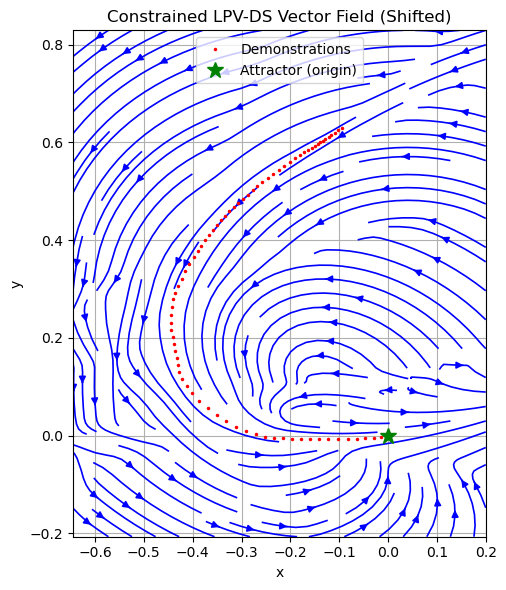

In [25]:
import numpy as np
from scipy.io import loadmat
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import cvxpy as cp

# === Step 1: Load the .mat file ===
mat_path = '/home/zhitao/exchange/phd_summer_course/hw/chalmers25-hw/hw2/part2/drawed_data/test/2.mat'
mat_data = loadmat(mat_path)

# === Step 2: Extract data and shift attractor to origin ===
Xi_ref = mat_data['Xi_ref']         # shape: (2, N)
Xi_dot_ref = mat_data['Data'][2:, :]  # shape: (2, N)
att = mat_data['att'].flatten()     # attractor position (2,)

# Shift to origin
Xi_ref_shifted = Xi_ref - att.reshape(-1, 1)

# === Step 3: Fit GMM ===
n_components = 5
gmm = GaussianMixture(n_components=n_components, covariance_type='full')
gmm.fit(Xi_ref_shifted.T)

# === Step 4: Compute Responsibilities ===
def compute_gammas(gmm, X):
    return gmm.predict_proba(X.T)

gammas = compute_gammas(gmm, Xi_ref_shifted)

# === Step 5: Estimate A_k and b_k with Lyapunov constraints ===
D, N = Xi_ref.shape
A_k_list = []
b_k_list = []

P = np.eye(D)
Q = -1e-3 * np.eye(D)

X = Xi_ref_shifted.T  # shape: (N, D)
Y = Xi_dot_ref.T      # shape: (N, D)

for k in range(n_components):
    gamma_k = gammas[:, k]  # shape: (N,)
    A = cp.Variable((D, D))
    b = cp.Variable(D)

    residuals = (X @ A.T + b - Y)
    weighted_error = cp.multiply(gamma_k[:, np.newaxis], residuals)

    objective = cp.Minimize(cp.sum_squares(weighted_error))
    constraints = [A.T @ P + P @ A << Q]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)

    A_k_list.append(A.value)
    b_k_list.append(b.value)

# === Step 6: Define LPV-DS ===
def lpv_ds(x, gmm, A_k_list, b_k_list):
    x = np.atleast_2d(x)
    gammas = compute_gammas(gmm, x.T)
    gammas = np.nan_to_num(gammas)
    dx = np.zeros_like(x)
    for k in range(len(A_k_list)):
        Ak = A_k_list[k]
        bk = b_k_list[k]
        dx += gammas[:, k:k+1] * (x @ Ak.T + bk)
    return dx

# === Step 7: Plot the LPV-DS Vector Field ===
margin = 0.2
x_min, x_max = Xi_ref_shifted[0].min() - margin, Xi_ref_shifted[0].max() + margin
y_min, y_max = Xi_ref_shifted[1].min() - margin, Xi_ref_shifted[1].max() + margin

grid_res = 40
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_res),
                             np.linspace(y_min, y_max, grid_res))
points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

vels = lpv_ds(points, gmm, A_k_list, b_k_list)

plt.figure(figsize=(8, 6))
plt.streamplot(x_grid, y_grid,
               vels[:, 0].reshape(x_grid.shape),
               vels[:, 1].reshape(y_grid.shape),
               color='b', density=1.2, linewidth=1.2)

# Plot demonstrations and attractor (in shifted frame)
plt.plot(Xi_ref_shifted[0], Xi_ref_shifted[1], 'r.', markersize=3, label='Demonstrations')
plt.plot(0, 0, 'g*', markersize=12, label='Attractor (origin)')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Constrained LPV-DS Vector Field (Shifted)')
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.legend()
plt.tight_layout()
plt.show()

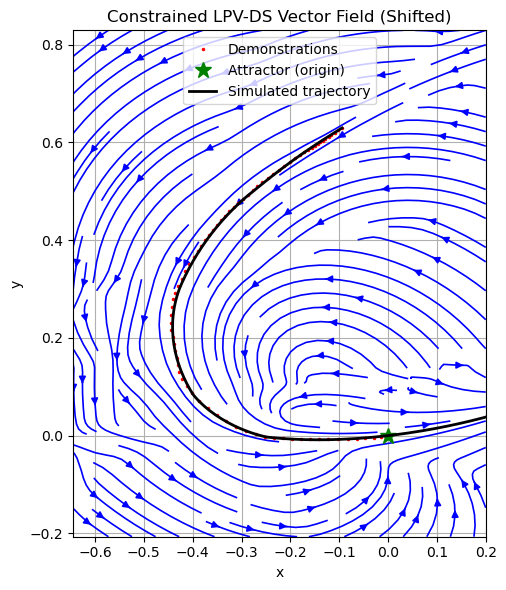

In [26]:
dt = 0.01
T = 750
traj = np.zeros((T, 2))
traj[0] = Xi_ref_shifted[:, 0]  # start from first demo point (shifted)

for t in range(1, T):
    dx = lpv_ds(traj[t-1], gmm, A_k_list, b_k_list)
    traj[t] = traj[t-1] + dt * dx[0]
    if np.linalg.norm(traj[t]) < 1e-3:
        traj = traj[:t+1]
        break

plt.figure(figsize=(8, 6))
plt.streamplot(x_grid, y_grid,
               vels[:, 0].reshape(x_grid.shape),
               vels[:, 1].reshape(y_grid.shape),
               color='b', density=1.2, linewidth=1.2)

# Plot demonstrations and attractor (in shifted frame)
plt.plot(Xi_ref_shifted[0], Xi_ref_shifted[1], 'r.', markersize=3, label='Demonstrations')
plt.plot(0, 0, 'g*', markersize=12, label='Attractor (origin)')
plt.plot(traj[:, 0], traj[:, 1], 'k-', linewidth=2, label='Simulated trajectory')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Constrained LPV-DS Vector Field (Shifted)')
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
def gamma_circular(x, center, radius):
    # x is shape (N, 2)
    diff = x - center
    sq_d = np.sum(diff**2, axis=1)  # shape (N,)
    gamma = sq_d - radius**2 + 1
    grad_gamma = 2 * diff  # shape (N, 2)
    return gamma, grad_gamma


In [28]:
def normal_modulation_matrix(gamma, grad_gamma):
    # gamma: (N,)
    # grad_gamma: (N, 2)
    M_list = []
    for i in range(len(gamma)):
        if gamma[i] < 1:
            M_list.append(np.eye(2))  # Inside obstacle: identity (could also be zeroed)
            continue
        n = grad_gamma[i] / (np.linalg.norm(grad_gamma[i]) + 1e-12)  # normal vector
        N = n.reshape(2,1)
        T = np.eye(2) - N @ N.T
        # Modulation scaling
        lam_n = 1 / gamma[i]  # Shrinks along normal
        lam_t = 1             # Tangential direction remains unchanged
        M = lam_n * N @ N.T + lam_t * T
        M_list.append(M)
    return np.array(M_list)  # Shape: (N, 2, 2)


In [34]:
# Define obstacle
# obstacle_center = np.array([-1.25, 0.0]) lpvds_1
obstacle_center = np.array([-0.3, 0.4])

obstacle_radius = 0.2

# Evaluate LPV-DS velocities at grid points
vels_nominal = lpv_ds(points, gmm, A_k_list, b_k_list)  # (N, 2)

# Compute obstacle modulation
gamma_vals, grad_gammas = gamma_circular(points, obstacle_center, obstacle_radius)
mod_matrices = normal_modulation_matrix(gamma_vals, grad_gammas)


# Apply modulation
vels_modulated = np.empty_like(vels_nominal)

# Apply modulation outside obstacle
outside = gamma_vals >= 1
vels_modulated[outside] = np.einsum('nij,nj->ni', mod_matrices[outside], vels_nominal[outside])

# Project velocity outward along gradient inside the obstacle
inside = gamma_vals < 1
n = grad_gammas[inside]
n_norm = np.linalg.norm(n, axis=1, keepdims=True)
n_unit = n / (n_norm + 1e-12)  # Normalize gradient
vel_mags = np.linalg.norm(vels_nominal[inside], axis=1, keepdims=True)
vels_modulated[inside] = vel_mags * n_unit



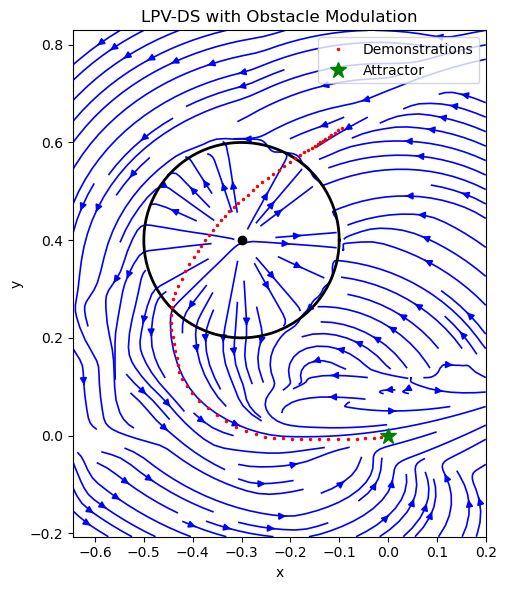

In [35]:
plt.figure(figsize=(8, 6))
plt.streamplot(x_grid, y_grid,
               vels_modulated[:, 0].reshape(x_grid.shape),
               vels_modulated[:, 1].reshape(y_grid.shape),
               color='b', density=1.2, linewidth=1.2)

# Draw obstacle
theta = np.linspace(0, 2*np.pi, 100)
x_obs = obstacle_radius * np.cos(theta) + obstacle_center[0]
y_obs = obstacle_radius * np.sin(theta) + obstacle_center[1]
plt.plot(x_obs, y_obs, 'k-', linewidth=2)
plt.plot(obstacle_center[0], obstacle_center[1], 'ko')

# Plot demos & attractor
plt.plot(Xi_ref_shifted[0], Xi_ref_shifted[1], 'r.', markersize=3, label='Demonstrations')
plt.plot(0, 0, 'g*', markersize=12, label='Attractor')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.xlabel('x')
plt.ylabel('y')
plt.title('LPV-DS with Obstacle Modulation')
plt.legend()

plt.tight_layout()
plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


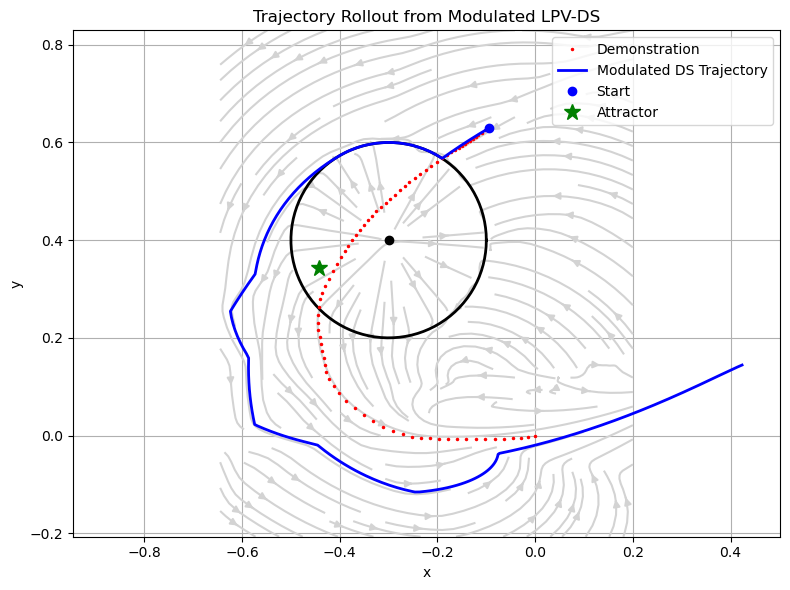

In [37]:
from scipy.integrate import solve_ivp

# === Define the modulated DS function ===
def lpv_ds_modulated(t, x):
    x = x.reshape(1, 2)  # shape (1, 2)
    
    # Nominal velocity from LPV-DS
    dx_nom = lpv_ds(x, gmm, A_k_list, b_k_list)  # shape (1,2)
    
    # Obstacle modulation
    gamma, grad = gamma_circular(x, obstacle_center, obstacle_radius)
    if gamma[0] >= 1:
        # Outside: apply normal-based modulation
        M = normal_modulation_matrix(gamma, grad)[0]
        dx_mod = M @ dx_nom.T
        return dx_mod.ravel()
    else:
        # Inside: project outward
        n = grad[0] / (np.linalg.norm(grad[0]) + 1e-12)
        speed = np.linalg.norm(dx_nom)
        return speed * n

# === Integration parameters ===
x0 = Xi_ref_shifted[:, 0]   # initial position (2,)
t_span = [0, 8]
dt = 0.01
t_eval = np.arange(t_span[0], t_span[1], dt)

# === Integrate the trajectory ===
sol = solve_ivp(lpv_ds_modulated, t_span, x0, t_eval=t_eval, rtol=1e-5)

# === Plot trajectory over modulated field ===
plt.figure(figsize=(8, 6))
plt.streamplot(x_grid, y_grid,
               vels_modulated[:, 0].reshape(x_grid.shape),
               vels_modulated[:, 1].reshape(y_grid.shape),
               color='lightgray', density=1.2)

# Obstacle
plt.plot(x_obs, y_obs, 'k-', linewidth=2)
plt.plot(obstacle_center[0], obstacle_center[1], 'ko')

# Demonstration
plt.plot(Xi_ref_shifted[0], Xi_ref_shifted[1], 'r.', label='Demonstration', markersize=3)

# Rollout trajectory
plt.plot(sol.y[0], sol.y[1], 'b-', linewidth=2, label='Modulated DS Trajectory')
plt.plot(sol.y[0, 0], sol.y[1, 0], 'bo', label='Start')
plt.plot(att[0], att[1], 'g*', markersize=12, label='Attractor')

# Formatting
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory Rollout from Modulated LPV-DS')
plt.axis('equal')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
